In [1]:
import timeit
from datetime import datetime
import socket
import os
import glob
from tqdm import tqdm

import torch
from tensorboardX import SummaryWriter
from torch import nn, optim

from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from dataloaders.dataset import VideoDataset
from network import R3D_model, C3D_model, R2Plus1D_model, Pac3D_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import random   

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
############################
####    Parameters      ####
############################
nEpochs = 10  # Number of epochs for training
resume_epoch = 0  # Default is 0, change if want to resume
useTest = True # See evolution of the test set when training
nTestInterval = 10 # Run on test set every nTestInterval epochs
save_epoch = 10 # Store a model every save_epoch
lr = 1e-3 # Learning rate
clip_len = 256 # frames of each video

###################################
####    Options of Dataset     ####
###################################
dataset = 'CIC-IDS2018-all-v1' 
modelName = 'Pac3D' 
saveName = modelName + '-' + dataset

if dataset == 'CIC-IDS2018-all':
    num_classes = 14
    set_seed(13)
elif dataset == 'CIC-IDS2018-all-v1':
    num_classes = 14
    set_seed(4)
elif dataset == 'CIC-IDS2018-v1-DoS':
    num_classes = 4
    set_seed(46)
elif dataset == 'CIC-IDS2018-v1-DDoS':
    num_classes = 3
    set_seed(19)
elif dataset == 'CIC-IDS2018-v1-Auth':
    num_classes = 2
    set_seed(43)
elif dataset == 'CIC-IDS2018-v1-Web':
    num_classes = 3
    set_seed(33)
elif dataset == 'CIC-IDS2018-v1-Other':
    num_classes = 2
    set_seed(23)
elif dataset == 'CIC-IDS2018-v2-DoS':
    num_classes = 4
    set_seed(50)
elif dataset == 'CIC-IDS2018-v3-DoS':
    num_classes = 4
    set_seed(8)
elif dataset == 'CIC-IDS2018-v3-DDoS':
    num_classes = 3
    set_seed(48)
elif dataset == 'CIC-IDS2018-v3-Auth':
    num_classes = 2
    set_seed(50)
elif dataset == 'CIC-IDS2018-v3-Web':
    num_classes = 3
    set_seed(38)
elif dataset == 'CIC-IDS2018-v3-Other':
    num_classes = 2
    set_seed(20)
else:
    print('No Dataset')
    raise NotImplementedError

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

Device being used: cuda:0


In [4]:

##########################################
####   Set Model result saving dir    ####
##########################################
save_dir_root = os.path.join("/SSD/p76111262/")
resume_epoch = 0

if resume_epoch != 0:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    run_id = int(runs[-1].split('_')[-1]) if runs else 0
else:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    if len(runs) == 0:
        run_id = 0
    else:
        run_id = max([int(i.split('_')[-1]) for i in runs]) + 1
save_dir = os.path.join(save_dir_root, 'run', 'run_' + str(run_id))


In [5]:
######################################
####   Load model & parameters    ####
######################################
if modelName == 'C3D':
    model = C3D_model.C3D(num_classes=num_classes, pretrained=False)
    train_params = [{'params': C3D_model.get_1x_lr_params(model), 'lr': lr},
                    {'params': C3D_model.get_10x_lr_params(model), 'lr': lr * 10}]
elif modelName == 'R2Plus1D':
    model = R2Plus1D_model.R2Plus1DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = [{'params': R2Plus1D_model.get_1x_lr_params(model), 'lr': lr},
                    {'params': R2Plus1D_model.get_10x_lr_params(model), 'lr': lr * 10}]
elif modelName == 'R3D':
    model = R3D_model.R3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = model.parameters()
elif modelName == 'Pac3D':
    model = Pac3D_model.Pac3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = model.parameters()
else:
    print('We only implemented C3D and R2Plus1D models.')
    raise NotImplementedError


In [6]:
######################################
####   Load model & parameters    ####
######################################
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(train_params, lr=lr, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # the scheduler divides the lr by 10 every 5 epochs

if resume_epoch == 0:
    print("Training {} from scratch...".format(modelName))
else:
    checkpoint = torch.load(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar'),
                    map_location=lambda storage, loc: storage)   # Load all tensors onto the CPU
    print("Initializing weights from: {}...".format(
        os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar')))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['opt_dict'])

print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))

model.to(device)
criterion.to(device)

log_dir = os.path.join(save_dir, 'models', datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname())
print("log dir:", log_dir)
writer = SummaryWriter(log_dir=log_dir)


Training Pac3D from scratch...
Total params: 5.66M


log dir: /SSD/p76111262/run/run_52/models/Jun20_11-11-43_uscc-ai-server


In [7]:

########################
####   Load Data    ####
########################
print('Training model on {} dataset...'.format(dataset))
train_dataloader = DataLoader(VideoDataset(dataset=dataset, split='train', clip_len=clip_len), batch_size=16, shuffle=True, num_workers=0)
test_dataloader  = DataLoader(VideoDataset(dataset=dataset, split='test', clip_len=clip_len), batch_size=16, num_workers=0)

train_size = len(train_dataloader.dataset)
test_size = len(test_dataloader.dataset)


Training model on CIC-IDS2018-all-v1 dataset...


In [8]:

train_losses = []
train_accs = []
val_losses = []
val_accs = []
y_pred = []
y_true = []

for epoch in range(resume_epoch, nEpochs):

    start_time = timeit.default_timer()

    # reset the running loss and corrects
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()

    for inputs, labels in tqdm(train_dataloader):
        # move inputs and labels to the device the training is taking place on
        labels = labels.type(torch.LongTensor)
        inputs = Variable(inputs, requires_grad=True).to(device)
        labels = Variable(labels).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        probs = nn.Softmax(dim=1)(outputs)
        preds = torch.max(probs, 1)[1]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size

    writer.add_scalar('data/train_loss_epoch', epoch_loss, epoch)
    writer.add_scalar('data/train_acc_epoch', epoch_acc, epoch)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
        
    print("[train] Epoch: {}/{} Loss: {} Acc: {}".format(epoch+1, nEpochs, epoch_loss, epoch_acc))
    stop_time = timeit.default_timer()
    print("Execution time: " + str(stop_time - start_time) + "\n")
    if epoch % save_epoch == (save_epoch - 1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'opt_dict': optimizer.state_dict(),
        }, os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar'))
        print("Save model at {}\n".format(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar')))

    if useTest and epoch % nTestInterval == (nTestInterval - 1):
        model.eval()
        start_time = timeit.default_timer()

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in tqdm(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            preds = torch.max(probs, 1)[1]
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(labels.view(-1).detach().cpu().numpy())

        epoch_loss = running_loss / test_size
        epoch_acc = running_corrects.double() / test_size
    
        writer.add_scalar('data/test_loss_epoch', epoch_loss, epoch)
        writer.add_scalar('data/test_acc_epoch', epoch_acc, epoch)

        precision = precision_score(y_true, y_pred, average=None)
        recall = recall_score(y_true, y_pred, average=None)


        print("[test] Epoch: {}/{} Loss: {} Acc: {}".format(epoch+1, nEpochs, epoch_loss, epoch_acc))
        stop_time = timeit.default_timer()
        print("Execution time: " + str(stop_time - start_time) + "\n")
        
writer.close()
torch.save(model.state_dict(), "/SSD/p76111262/"+modelName+"_run"+str(run_id)+".pth")


100%|██████████| 133/133 [02:41<00:00,  1.22s/it]


[train] Epoch: 1/10 Loss: 1.897527335947538 Acc: 0.46408317580340264
Execution time: 161.83208855986595



100%|██████████| 133/133 [02:42<00:00,  1.22s/it]


[train] Epoch: 2/10 Loss: 1.7309000262240606 Acc: 0.4905482041587902
Execution time: 162.23902490595356



100%|██████████| 133/133 [02:42<00:00,  1.22s/it]


[train] Epoch: 3/10 Loss: 1.7223657538624928 Acc: 0.4886578449905482
Execution time: 162.09898506687023



100%|██████████| 133/133 [02:41<00:00,  1.21s/it]


[train] Epoch: 4/10 Loss: 1.7335732677257805 Acc: 0.4905482041587902
Execution time: 161.4375555620063



100%|██████████| 133/133 [02:41<00:00,  1.21s/it]


[train] Epoch: 5/10 Loss: 1.7307270298833433 Acc: 0.4905482041587902
Execution time: 161.05039467290044



100%|██████████| 133/133 [02:41<00:00,  1.22s/it]


[train] Epoch: 6/10 Loss: 1.7311125761619812 Acc: 0.4872400756143667
Execution time: 161.66535543114878



100%|██████████| 133/133 [02:41<00:00,  1.22s/it]


[train] Epoch: 7/10 Loss: 1.7266207480475673 Acc: 0.4910207939508507
Execution time: 161.9056667489931



100%|██████████| 133/133 [02:41<00:00,  1.22s/it]


[train] Epoch: 8/10 Loss: 1.7390439271476184 Acc: 0.4862948960302458
Execution time: 161.9379576020874



100%|██████████| 133/133 [02:40<00:00,  1.21s/it]


[train] Epoch: 9/10 Loss: 1.7332806659330717 Acc: 0.4862948960302458
Execution time: 160.82050321414135



100%|██████████| 133/133 [02:41<00:00,  1.21s/it]


[train] Epoch: 10/10 Loss: 1.7323395500561691 Acc: 0.4858223062381853
Execution time: 161.52657934790477

Save model at /SSD/p76111262/run/run_52/models/Pac3D-CIC-IDS2018-all-v1_epoch-9.pth.tar



100%|██████████| 34/34 [00:31<00:00,  1.09it/s]

[test] Epoch: 10/10 Loss: 1.683324019338676 Acc: 0.512241054613936
Execution time: 31.089329421985894




/home/p76111262/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


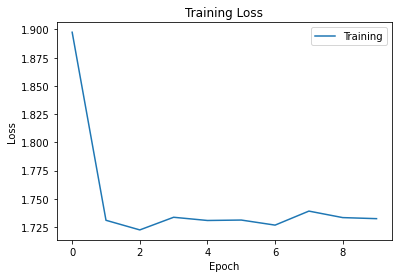

In [9]:
import matplotlib.pyplot as plt
x = list(range(nEpochs))
plt.plot(x, train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training'])

plt.savefig(save_dir + '/training_loss.png')
plt.show()

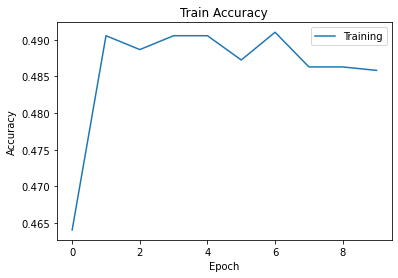

In [10]:
x = list(range(nEpochs))
np_train_accs = []
for i in range(len(train_accs)):
    np_train_accs.append(train_accs[i].cpu().numpy())

plt.plot(x, np_train_accs)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training'])

plt.savefig(save_dir + '/train_acc.png')
plt.show()

In [11]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    y_pred = []   #保存預測label
    y_true = []   #保存實際label
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            # move inputs and labels to the device the training is taking place on
            labels = labels.type(torch.LongTensor)
            inputs = Variable(inputs, requires_grad=True).to(device)
            labels = Variable(labels).to(device)
            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            preds = torch.max(probs, 1)[1]
            num_samples += 1
            num_correct += torch.sum(preds == labels.data)
            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(labels.view(-1).detach().cpu().numpy())
        acc = num_correct.double() / test_size
        print("[test] Acc: {}".format(acc))
    return y_pred, y_true
        

In [12]:
checkpoint = torch.load(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(nEpochs - 1) + '.pth.tar'), 
                        map_location=lambda storage, loc: storage)   
print("Initializing weights from: {}...".format(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(nEpochs - 1) + '.pth.tar')))
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['opt_dict'])
y_pred, y_true = check_accuracy(test_dataloader, model)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Initializing weights from: /SSD/p76111262/run/run_52/models/Pac3D-CIC-IDS2018-all-v1_epoch-9.pth.tar...


100%|██████████| 34/34 [00:23<00:00,  1.44it/s]

[test] Acc: 0.512241054613936
Precision:  0.4609999450016974
Recall:  0.49265873015873013
F1:  0.4218227410967807



/home/p76111262/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/tmp/ipykernel_3558224/2492310596.py:4: RuntimeWarning: invalid value encountered in true_divide
  per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)


['Botnet', 'BruteForce-FTP', 'BruteForce-SSH', 'BruteForce-Web', 'BruteForce-XSS', 'DDoS_HOIC', 'DDoS_LOIC-HTTP', 'DDoS_LOIC-UDP', 'DoS_GoldenEye', 'DoS_Hulk', 'DoS_SlowHTTPTest', 'DoS_Slowloris', 'Infiltration', 'SQL_Injection']
[       nan        nan 0.18957346 0.78431373 1.         0.64285714
 0.7        0.90909091 1.         0.75757576 0.47058824        nan
        nan        nan]


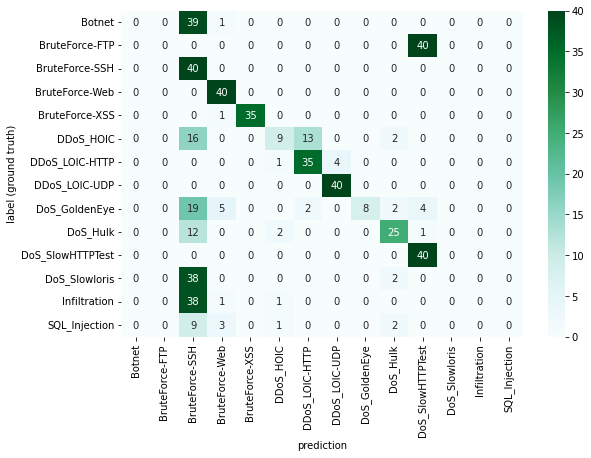

In [15]:

# 製作混淆矩陣
cf_matrix = confusion_matrix(y_true, y_pred)                               
# 計算每個class的accuracy
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)                   

class_names = []
label_txt = os.path.join('dataloaders', dataset + ".txt")  # 這裡要改成你的label.txt路徑
with open(label_txt, 'r') as f:
    for line in f:
        class_names.append(line.strip())
        
print(class_names)
print(per_cls_acc)                                            

# 開始繪製混淆矩陣並存檔
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)    
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig(save_dir + '/confusion_matrix.png')

In [14]:
print(y_pred)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 5, 2, 5, 2, 2, 2, 6, 6, 6, 2, 2, 6, 2, 5, 5, 2, 6, 5, 2, 5, 6, 2, 6, 6, 2, 2, 2, 6, 9, 5, 2, 6, 2, 9, 2, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6, 5, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 10, 8, 2